In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%load_ext autoreload
%autoreload 2
from implementations_tanguy import *

In [2]:
from helpers import *

# load data.
particle, products, ids = load_csv_data('data/train.csv', sub_sample= True)

In [3]:
# build sampled x and y.
seed = 1
y = np.expand_dims(particle, axis=1)
y, X = sample_data(y, products, seed, size_samples=1000)
x, mean_x, std_x = standardize(X)

tx = np.c_[np.ones((y.shape[0], 1)), x]

### Gradient Descent

In [4]:
print(y.shape, x.shape)
np.seterr(divide = 'ignore') 
initial_w = np.zeros((tx.shape[1], 1))

(1000, 1) (1000, 30)


We need to find a balance between the number of iteration and gamma (the step size), the shorter the number of iterations we do, the faster it runs but we stay far away from an optimum loss

In [6]:
start_time = time.time()
w_gd, loss_gd = mean_squared_error_gd(y, tx, initial_w, 10, 0.001)
print("loss:", np.sqrt(2*loss_gd[0][0]), "--- %s seconds ---" % (time.time() - start_time))

loss: 0.9887157191548617 --- 0.0010023117065429688 seconds ---


If we increment too much the number of iterations then the code becomes really slow

In [8]:
start_time = time.time()
w_gd, loss_gd = mean_squared_error_gd(y, tx, initial_w, 1000000, 0.001)
print("loss:", np.sqrt(2*loss_gd[0][0]), "--- %s seconds ---" % (time.time() - start_time))

loss: 0.8127890774559601 --- 29.194424390792847 seconds ---


As we can see our loss has reduced significantly, however it took too long to compute

In [9]:
start_time = time.time()
w_gd, loss_gd = mean_squared_error_gd(y, tx, initial_w, 10000, 0.001)
print("loss:", np.sqrt(2*loss_gd[0][0]), "--- %s seconds ---" % (time.time() - start_time))

loss: 0.8164649473516559 --- 0.3001716136932373 seconds ---


Here we can see a good balance, the loss has barely increased and the computing time is much lower.
The logic is similar respect to gamma, the shorter the step size is, the more iterations we would need to get to the optimal loss

In [10]:
start_time = time.time()
w_gd, loss_gd = mean_squared_error_gd(y, tx, initial_w, 10000, 0.0000001)
print("loss:", np.sqrt(2*loss_gd[0][0]), "--- %s seconds ---" % (time.time() - start_time))

loss: 0.9986612313087819 --- 0.2922194004058838 seconds ---


And the larger the gamma, we might miss the optimal loss and diverge

### Stochastic Gradient Descent

In [36]:
print(y.shape, x.shape)

np.seterr(divide = 'ignore') 

initial_w = np.zeros((tx.shape[1], 1))

start_time = time.time()

w_sgd, loss_sgd = mean_squared_error_sgd(y, tx, initial_w, 1, 100000, 0.001)
print("loss:", np.sqrt(2*loss_sgd[0][0]), "--- %s seconds ---" % (time.time() - start_time))

(1000, 1) (1000, 30)
loss: 0.8168648518988467 --- 6.728437185287476 seconds ---


### EDA

import pandas as pd
X_panda = pd.DataFrame(X)

plt.figure(figsize=(80,30))
plt.rc('font',size=30)
sns.heatmap(data = X_panda.corr().round(2),vmin = -1, vmax = 1, cmap = 'coolwarm',linewidths = .5, annot=True, annot_kws = {"size":30})
plt.show()

along the diagonal 1 --> my correlation between the same feature
4,5,6,12 --> seem to be correlated (correlation score between 0.95 and 1)
from 21 to 29 --> more or less correlated
from 3 to 12 and from 21 to 29 seem to be correlated

### LEAST SQUARES WITH NORMAL EQUATIONS

In [4]:
print(y.shape, x.shape)

w_ls , loss_ls = least_squares(y,tx)
print(np.sqrt(2*loss_ls[0][0]))

#print(w_ls)

(400, 1) (400, 30)
0.7909509230712314


### Logistic Regression

In [29]:
np.seterr(divide = 'ignore') 

initial_w = np.zeros((tx.shape[1], 1))

iter_num = 10000000
gamma = 0.00001
w_lr, loss_lr = logistic_regression(y,tx, initial_w, iter_num, gamma)
print("loss", np.sqrt(2*loss_lr[0][0]))
#print(w_ls, "\n", w_lr)

#the loss becomes negative if we choose to big of a gamma and number of iterations
#it seems that at some point we go past the global minimum and start diverging 
#having a very small gamma solves this problem
#the minimal value I could find is 0.8540791315850801 (with rmse 100 samples)


# with 400 samples --> when gamma = 0.0001
# it diverges because when iterations increases the loss increases
# with gamma = 0.00007 or lower --> it does not diverge (RMSE 0.88633 with 10000 iter, same for 100000)
#after 10000 iter the loss reduces very slowly --> we are close to the optimum and the remaining 90000 iter are
# just fine refinements (we are moving around the optimum)
# as gamma increases --> computational time decreases but only under a certain threshold


loss 0.905290576892303


In [30]:
print(np.linalg.norm(w_lr))

# as the number of iterations increases the norm increases

0.18047572392310723


### Linear Cross-validation (half-half)

In [5]:
from cross_validation import *



k_indices = build_k_indices(y, 2, 1)
loss_train, loss_test = cross_validation_linear_gd(y, x,  k_indices, 1)
print("train loss : ", loss_train, "test loss : ", loss_test)

#there s some overfit with linear regression

train loss :  [[0.84321116]] test loss :  [[0.84932374]]


### cross_validation of logistic regression 

In [31]:
loss_train, loss_test = cross_validation_logistic_regression(y, x,  k_indices, 1)
print("train loss : ", loss_train, "test loss : ", loss_test)

# model is generalizable (test loss is lower than train loss)
# logistic regression is more appropriate to this dataset as y is binary
# there might be a bit of underfit 

train loss :  [[0.90813365]] test loss :  [[0.88699132]]


### Find best lambda for ridge regression

 the choice of lambda which leads to the best test rmse is 0.07880 with a test rmse of 0.843


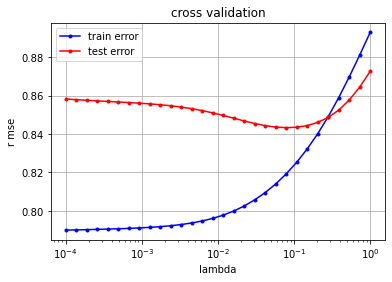

In [8]:
best_lambda, best_rmse = find_best_lambda_ridge_regression(x, y, 7, np.logspace(-4, 0, 30))

### Penalized logistic regression

In [40]:
np.seterr(divide = 'ignore') 

initial_w = np.zeros((tx.shape[1], 1))

lambda_ = 1

w_lr, loss_lr = reg_logistic_regression(y,tx, lambda_, initial_w, 100000, 0.00001)
print("loss", np.sqrt(2*loss_lr[0][0]))
#print(w_ls, "\n", w_lr)

# if gamma bigger than 0.00001 --> diverge
# if lambda = 0 --> no regularization (loss 0.88632)
# if lambda increases --> loss increases (0.8898)--> l2 norm of final weights vector decreases
# we avoid overfitting because we penalize large weights with the L2 norm
# if we set lambda to zero --> we go back to normal logistic regression
# 

loss 0.9302020251662649


In [41]:
np.linalg.norm(w_lr)

0.1297329413911314

### Cross-validation of penalized logistic regression

In [48]:
from cross_validation import *
k=1
lambda_=0.000001
loss_train, loss_test = cross_validation_reg_logistic_regression(y, x, k_indices, k,lambda_)
print("train loss : ", loss_train, "test loss : ", loss_test)

# we see that the loss both with logistic regression and reg logistic regression is similar
# no need to regularize because the data are not lineraly separable 
# (if they were --> we would never find a vector with logistic regression as it would go to infinity)
# test loss is better with log than reg log


train loss :  [[0.90813373]] test loss :  [[0.8869914]]


### Find best lambda for regularized logistic regression

 the choice of lambda which leads to the best test rmse is 0.00010 with a test rmse of 0.892


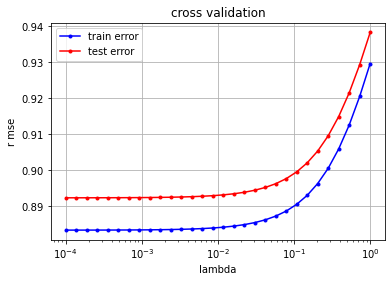

In [12]:
best_lambda, best_rmse = find_best_lambda_reg_logistic_regression(x, y, 7, np.logspace(-4, 0, 30))

# we see that when regularizing --> we just increase rmse both for train and test 
# do not understand why reversed